#### **Cell 1: Setup & Mount Drive**

* **What it does:** Connects Colab to your Google Drive so you can save files permanently.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Configuration paths
ORIGINAL_DATA_DIR = '/content/drive/MyDrive/CNN/dataset'
AUGMENTED_DATA_DIR = '/content/drive/MyDrive/CNN/augmented'
PROCESSED_DATA_DIR = '/content/drive/MyDrive/CNN/features'
MODELS_DIR = '/content/drive/MyDrive/CNN/saved_models'
TRAIN_DIR = '/content/drive/MyDrive/CNN/split/train'
VAL_DIR = '/content/drive/MyDrive/CNN/split/val'
RESULTS_DIR = '/content/drive/MyDrive/CNN/results'
MODEL_FILENAME = 'cnn_feature_extractor.pth'

CLASS_NAMES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash','unknown']
TARGET_IMAGES_PER_CLASS = 500

Mounted at /content/drive


#### **Cell 2: Data Splitting**

* **What it does:** Takes your raw images and splits them into Train (80%) and Validation (20%) folders.

In [ ]:
def split_dataset(original_dir, train_dir, val_dir, split_ratio=0.8, seed=42):
    """
    Split dataset into train and validation sets BEFORE augmentation
    """
    print("\n" + "=" * 70)
    print("SPLITTING DATASET INTO TRAIN / VALIDATION")
    print("=" * 70)

    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(val_dir):
        shutil.rmtree(val_dir)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for class_name in CLASS_NAMES:
        class_path = os.path.join(original_dir, class_name)
        if not os.path.exists(class_path):
            continue

        images = [f for f in os.listdir(class_path)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

        train_imgs, val_imgs = train_test_split(
            images, train_size=split_ratio, random_state=seed, shuffle=True
        )

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        for img in train_imgs:
            shutil.copy2(
                os.path.join(class_path, img),
                os.path.join(train_dir, class_name, img)
            )

        for img in val_imgs:
            shutil.copy2(
                os.path.join(class_path, img),
                os.path.join(val_dir, class_name, img)
            )

        print(f"[SPLIT] {class_name}: {len(train_imgs)} train | {len(val_imgs)} val")

    print("[OK] Dataset split completed\n")

if __name__ == "__main__":

    split_dataset(ORIGINAL_DATA_DIR, TRAIN_DIR, VAL_DIR, split_ratio=0.8, seed=42)

#### **Cell 3: Augmentation & Unknown Generation (Phase 1)**

* **What it does:** Rotates/Zooms images to reach 500 per class. **Crucially**, it generates the "Unknown" class using the robust logic (Blur + Black boxes + Noise) we discussed.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from tqdm import tqdm
import shutil

ROTATION_RANGE = 30  # degrees
BRIGHTNESS_RANGE = (0.7, 1.3)  # 70% to 130%
ZOOM_RANGE = (0.8, 1.2)  # 80% to 120%
FLIP_PROBABILITY = 0.5

# ============================================================================
# STEP 1: DATASET EXPLORATION
# ============================================================================

def explore_dataset(data_dir):
    """
    Analyze the original dataset and print statistics
    """
    print("=" * 70)
    print("DATASET EXPLORATION")
    print("=" * 70)

    class_stats = {}
    total_images = 0

    for class_name in CLASS_NAMES:
        class_path = os.path.join(data_dir, class_name)

        if not os.path.exists(class_path):
            print(f"WARNING: Folder '{class_name}' not found!")
            continue

        # Count images
        images = [f for f in os.listdir(class_path)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        count = len(images)
        total_images += count

        class_stats[class_name] = {
            'count': count,
            'images': images
        }

        # Sample image dimensions
        if count > 0:
            sample_img_path = os.path.join(class_path, images[0])
            sample_img = cv2.imread(sample_img_path)
            if sample_img is not None:
                height, width = sample_img.shape[:2]
                class_stats[class_name]['sample_size'] = (width, height)

    # Print statistics
    print(f"[STATS] Dataset Statistics:")
    print(f"{'Class':<15} {'Count':<10} {'Percentage':<12} {'Sample Size'}")
    print("-" * 70)

    for class_name in CLASS_NAMES:
        if class_name in class_stats:
            count = class_stats[class_name]['count']
            percentage = (count / total_images) * 100 if total_images > 0 else 0
            sample_size = class_stats[class_name].get('sample_size', 'N/A')
            print(f"{class_name:<15} {count:<10} {percentage:>6.2f}%      {sample_size}")

    print("-" * 70)
    print(f"{'TOTAL':<15} {total_images:<10} 100.00%")
    print()

    # Identify imbalances
    if class_stats:
        counts = [stats['count'] for stats in class_stats.values()]
        max_count = max(counts)
        min_count = min(counts)
        imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

        print(f"[ANALYSIS] Class Imbalance Analysis:")
        print(f"   Max class size: {max_count}")
        print(f"   Min class size: {min_count}")
        print(f"   Imbalance ratio: {imbalance_ratio:.2f}x")

        if imbalance_ratio > 2:
            print(f"   Warning: Significant imbalance detected! Augmentation needed.")
        else:
            print(f"   Classes are relatively balanced.")

    print("\n" + "=" * 70 + "\n")

    return class_stats, total_images


# ============================================================================
# STEP 2: AUGMENTATION FUNCTIONS
# ============================================================================

def rotate_image(image, angle):
    """Rotate image by given angle"""
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, matrix, (width, height),
                             borderMode=cv2.BORDER_REFLECT)
    return rotated


def adjust_brightness(image, factor):
    """Adjust image brightness"""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:, :, 2] = hsv[:, :, 2] * factor
    hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)


def zoom_image(image, zoom_factor):
    """Zoom in/out on image"""
    height, width = image.shape[:2]
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

    # Resize
    resized = cv2.resize(image, (new_width, new_height))

    # Crop or pad to original size
    if zoom_factor > 1:  # Zoom in - crop center
        start_y = (new_height - height) // 2
        start_x = (new_width - width) // 2
        result = resized[start_y:start_y+height, start_x:start_x+width]
    else:  # Zoom out - pad
        result = np.zeros((height, width, 3), dtype=np.uint8)
        start_y = (height - new_height) // 2
        start_x = (width - new_width) // 2
        result[start_y:start_y+new_height, start_x:start_x+new_width] = resized

    return result


def flip_image(image, flip_code):
    """Flip image horizontally (1) or vertically (0)"""
    return cv2.flip(image, flip_code)


def translate_image(image, tx, ty):
    """Translate image by tx, ty pixels"""
    height, width = image.shape[:2]
    matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(image, matrix, (width, height),
                                borderMode=cv2.BORDER_REFLECT)
    return translated


def augment_image(image):
    """
    Apply random augmentation to a single image
    Returns the augmented image
    """
    img = image.copy()

    # Random rotation
    if random.random() > 0.3:
        angle = random.uniform(-ROTATION_RANGE, ROTATION_RANGE)
        img = rotate_image(img, angle)

    # Random brightness
    if random.random() > 0.3:
        factor = random.uniform(BRIGHTNESS_RANGE[0], BRIGHTNESS_RANGE[1])
        img = adjust_brightness(img, factor)

    # Random zoom
    if random.random() > 0.3:
        zoom = random.uniform(ZOOM_RANGE[0], ZOOM_RANGE[1])
        img = zoom_image(img, zoom)

    # Random horizontal flip
    if random.random() > 0.5:
        img = flip_image(img, 1)

    # Random translation
    if random.random() > 0.4:
        height, width = img.shape[:2]
        tx = random.randint(-int(width*0.1), int(width*0.1))
        ty = random.randint(-int(height*0.1), int(height*0.1))
        img = translate_image(img, tx, ty)

    return img


# ============================================================================
# STEP 3: AUGMENTATION PIPELINE
# ============================================================================

def augment_class(class_name, original_images, original_dir, output_dir, target_count):
    """
    Augment a single class to reach target_count images
    """
    current_count = len(original_images)
    needed = target_count - current_count

    print(f"[PROCESSING] Processing class: {class_name}")
    print(f"   Original: {current_count} images")
    print(f"   Target: {target_count} images")
    print(f"   Need to generate: {needed} images")

    # Create output directory
    class_output_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_output_dir, exist_ok=True)

    # Copy original images
    print(f"   - Copying original images...")
    for img_name in original_images:
        src = os.path.join(original_dir, class_name, img_name)
        dst = os.path.join(class_output_dir, img_name)
        shutil.copy2(src, dst)

    # Generate augmented images
    if needed > 0:
        print(f"   - Generating {needed} augmented images...")

        aug_count = 0
        with tqdm(total=needed, desc=f"   Augmenting {class_name}") as pbar:
            while aug_count < needed:
                # Randomly select an original image
                original_img_name = random.choice(original_images)
                original_img_path = os.path.join(original_dir, class_name, original_img_name)

                # Read image
                img = cv2.imread(original_img_path)
                if img is None:
                    continue

                # Augment
                aug_img = augment_image(img)

                # Save with unique name
                base_name = os.path.splitext(original_img_name)[0]
                ext = os.path.splitext(original_img_name)[1]
                aug_img_name = f"{base_name}_aug_{aug_count}{ext}"
                aug_img_path = os.path.join(class_output_dir, aug_img_name)

                cv2.imwrite(aug_img_path, aug_img)

                aug_count += 1
                pbar.update(1)

    final_count = len(os.listdir(class_output_dir))
    print(f"   [OK] Final count: {final_count} images")

    return final_count


# ============================================================================
# STEP 4: UNKNOWN CLASS GENERATION
# ============================================================================

def generate_unknown_class(augmented_dir, target_count=400):
    """
    Generate Unknown class (ID: 6) from:
    1. Heavily blurred existing images
    2. Mixed/ambiguous samples
    """
    print("\n" + "=" * 70)
    print("GENERATING UNKNOWN CLASS (Class 6)")
    print("=" * 70)

    unknown_dir = os.path.join(augmented_dir, 'unknown')
    os.makedirs(unknown_dir, exist_ok=True)

    all_images = []

    # Collect all existing images
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(augmented_dir, class_name)
        if os.path.exists(class_dir):
            images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
            all_images.extend(images)

    print(f"\n[STATS] Generating {target_count} unknown samples...")
    print(f"   Strategy: Heavy blur + random transformations")

    with tqdm(total=target_count, desc="   Creating unknown samples") as pbar:
        for i in range(target_count):
            # Randomly select an image
            img_path = random.choice(all_images)
            img = cv2.imread(img_path)

            if img is None:
                continue

            # Apply heavy blur (this makes it "unknown")
            blur_amount = random.randint(15, 35)
            if blur_amount % 2 == 0:
                blur_amount += 1
            img = cv2.GaussianBlur(img, (blur_amount, blur_amount), 0)

            # Optionally add more distortions
            # STRATEGY 1: Cutout (Black blocks to hide features)
            # This teaches model that "missing info" is not a specific class
            for _ in range(random.randint(1, 4)):
                x1 = random.randint(0, w)
                y1 = random.randint(0, h)
                cv2.rectangle(img, (x1, y1), (x1+60, y1+60), (0,0,0), -1)

            # Pixel Noise (Texture destruction)
            if random.random() > 0.5:
                noise = np.random.normal(0, 40, img.shape).astype(np.uint8)
                img = cv2.add(img, noise)

            # Save
            unknown_img_name = f"unknown_{i:04d}.jpg"
            unknown_img_path = os.path.join(unknown_dir, unknown_img_name)
            cv2.imwrite(unknown_img_path, img)

            pbar.update(1)

    final_count = len(os.listdir(unknown_dir))
    print(f"\n   [OK] Generated {final_count} unknown samples")
    print("=" * 70 + "\n")

    return final_count


# ============================================================================
# STEP 5: VISUALIZATION
# ============================================================================

def visualize_samples(augmented_dir):
    """
    Display sample images from each class
    """
    print("\n[INFO] Visualizing samples from each class...")

    all_classes = CLASS_NAMES + ['unknown']
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for idx, class_name in enumerate(all_classes):
        class_dir = os.path.join(augmented_dir, class_name)

        if os.path.exists(class_dir):
            images = [f for f in os.listdir(class_dir)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

            if images:
                # Select a random image
                sample_img_name = random.choice(images)
                sample_img_path = os.path.join(class_dir, sample_img_name)
                img = cv2.imread(sample_img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                axes[idx].imshow(img)
                axes[idx].set_title(f"{class_name.capitalize()} ({len(images)} images)")
                axes[idx].axis('off')

    # Hide last empty subplot
    if len(all_classes) < len(axes):
        axes[-1].axis('off')

    plt.tight_layout()
    plt.savefig('dataset_samples.png', dpi=150, bbox_inches='tight')
    print("   [OK] Saved visualization to 'dataset_samples.png'")
    plt.show()


def plot_class_distribution(augmented_dir):
    """
    Plot bar chart of class distribution
    """
    print("\n[CHART] Creating class distribution chart...")

    all_classes = CLASS_NAMES + ['unknown']
    counts = []

    for class_name in all_classes:
        class_dir = os.path.join(augmented_dir, class_name)
        if os.path.exists(class_dir):
            count = len([f for f in os.listdir(class_dir)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
            counts.append(count)
        else:
            counts.append(0)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(all_classes)), counts, color='steelblue', alpha=0.8)
    plt.xlabel('Class', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
    plt.title('Augmented Dataset Distribution', fontsize=14, fontweight='bold')
    plt.xticks(range(len(all_classes)),
               [c.capitalize() for c in all_classes],
               rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add count labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}',
                ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
    print("   [OK] Saved chart to 'class_distribution.png'")
    plt.show()


# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    """
    Main execution pipeline
    """
    print("\n" + "=" * 25)
    print("PHASE 1: DATA PREPARATION & AUGMENTATION")
    print("=" * 25 + "\n")

    # Step 1: Explore original dataset
    class_stats, total_original = explore_dataset(TRAIN_DIR)

    if not class_stats:
        print("[ERROR] Error: No valid dataset found!")
        return

    # Step 2: Create output directory
    os.makedirs(AUGMENTED_DATA_DIR, exist_ok=True)

    # Step 3: Augment each class
    print("\n" + "=" * 70)
    print("AUGMENTATION PIPELINE")
    print("=" * 70)

    augmented_stats = {}

    for class_name in CLASS_NAMES:
        if class_name in class_stats:
            original_images = class_stats[class_name]['images']
            final_count = augment_class(
                class_name,
                original_images,
                ORIGINAL_DATA_DIR,
                AUGMENTED_DATA_DIR,
                TARGET_IMAGES_PER_CLASS
            )
            augmented_stats[class_name] = final_count

    # Step 4: Generate Unknown class
    unknown_count = generate_unknown_class(AUGMENTED_DATA_DIR, target_count=400)
    augmented_stats['unknown'] = unknown_count

    # Step 5: Print final summary
    print("\n" + "=" * 70)
    print("FINAL SUMMARY")
    print("=" * 70)

    total_augmented = sum(augmented_stats.values())
    increase_percentage = ((total_augmented - total_original) / total_original) * 100

    print(f"\n[STATS] Final Dataset Statistics:")
    print(f"{'Class':<15} {'Original':<12} {'Augmented':<12} {'Increase'}")
    print("-" * 70)

    # Iterate only over classes that were present in the original dataset
    # The 'unknown' class was not in the original dataset, so exclude it here
    for class_name in [cn for cn in CLASS_NAMES if cn != 'unknown']:
        original = class_stats[class_name]['count']
        augmented = augmented_stats.get(class_name, 0)
        increase = augmented - original
        print(f"{class_name:<15} {original:<12} {augmented:<12} +{increase}")

    # Print the 'unknown' class details separately, as it had 0 original images
    print(f"{'unknown':<15} {0:<12} {unknown_count:<12} +{unknown_count}")
    print("-" * 70)
    print(f"{'TOTAL':<15} {total_original:<12} {total_augmented:<12} "
          f"+{total_augmented - total_original} ({increase_percentage:.1f}%)")

    if increase_percentage >= 30:
        print(f"\n[SUCCESS] Dataset increased by {increase_percentage:.1f}% (target: 30%)")
    else:
        print(f"\n[WARNING] Dataset only increased by {increase_percentage:.1f}% "
              f"(target: 30%)")

    print("\n" + "=" * 70)


if __name__ == "__main__":
    main()

#### **Cell 4: CNN Feature Extraction (Phase 2)**

* **What it does:** Downloads ResNet50, trains it briefly on your data to learn features, then saves the "Feature Vectors" (numerical representations of images) to `.npy` files.

In [ ]:

"""
Phase 2 :CNN Feature Extractor

This file is a feature-extraction pipeline with a
compact PyTorch CNN training script that uses a pretrained ResNet50
to learn features (and save weights). The implementation is organized
into configuration, helpers, training/validation loops, and a main
pipeline.
"""

import os
import datetime
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle

# CONFIGURATION

# Training configuration
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 20
LR = 3e-5
patience = 3
epochs_without_improvement = 0


FEATURES_DIR = os.environ.get('FEATURES_DIR', '/content/drive/MyDrive/CNN//features')

# TRANSFORMS & DATASET HELPERS

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def is_valid_image(path: str) -> bool:
    """Quickly check an image file for basic integrity using PIL.

    Returns True when the file opens and verifies; False otherwise.
    Prints a short message for skipped files.
    """
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except Exception:
        print("Skipping corrupted file:", path)
        return False


def get_device():
    """Return torch.device: CUDA if available and not forced off, else CPU.

    Honor env var `FORCE_CPU=1` to force CPU even when CUDA is available.
    """
    force_cpu = os.environ.get('FORCE_CPU', '') in ('1', 'true', 'True')
    if not force_cpu and torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')


def prepare_datasets(dataset_path: str):
    """Load ImageFolder, filter invalid files, and split into train/val.

    Returns train_loader, val_loader and number of classes.
    """
    train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform, is_valid_file=is_valid_image)
    val_dataset   = datasets.ImageFolder(root=VAL_DIR, transform=transform, is_valid_file=is_valid_image)
    num_classes = len(train_dataset.classes)
    print("Classes:", train_dataset.classes)
    print(f"Training images: {len(train_dataset)}, Validation images: {len(val_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    return train_loader, val_loader, num_classes


def extract_and_cache_features(dataset_path: str = TRAIN_DIR, weights_path: str = None, overwrite: bool = False):
    """Extract pooled CNN features using ResNet backbone and cache to .npy files.

    Saves: X_train.npy, X_val.npy, X_test.npy, y_train.npy, y_val.npy, y_test.npy
    under `FEATURES_DIR` (default 'data/features'). Splits dataset using TRAIN_RATIO.
    """
    os.makedirs(FEATURES_DIR, exist_ok=True)

    # If files exist and not overwriting, skip
    expected = [os.path.join(FEATURES_DIR, n) for n in (
        'X_train.npy','X_val.npy','X_test.npy','y_train.npy','y_val.npy','y_test.npy')]
    if not overwrite and all(os.path.exists(p) for p in expected):
        print(f"Feature files already exist in {FEATURES_DIR}, use overwrite=True to regenerate.")
        return

    # Build dataset
    full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform, is_valid_file=is_valid_image)
    if len(full_dataset) == 0:
        raise RuntimeError(f"No images found in {dataset_path}")

    device = get_device()
    print('Using device for feature extraction:', device)

    # Load model and weights if available
    try:
        model = models.resnet50(pretrained=False)
    except Exception:
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

    # Try to load provided weights or default saved model
    if weights_path is None:
        weights_path = os.path.join(MODEL_DIR, MODEL_FILENAME)

    if weights_path and os.path.exists(weights_path):
        try:
            state = torch.load(weights_path, map_location=device)
            model.load_state_dict(state)
            print(f"Loaded CNN weights from {weights_path}")
        except Exception:
            # partial load: update matching shapes
            sd = model.state_dict()
            filtered = {k: v for k, v in state.items() if k in sd and sd[k].shape == v.shape}
            sd.update(filtered)
            model.load_state_dict(sd)
            print("Loaded subset of weights (partial load)")
    else:
        try:
            model = models.resnet50(pretrained=True)
            print('No saved weights found; using ImageNet pretrained backbone')
        except Exception:
            print('Warning: using randomly initialized ResNet (no pretrained weights)')

    model = model.to(device)
    model.eval()

    # Feature extractor: everything except the final fc layer
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()


    def _compute(ds):

        loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        feats = []
        labels = []
        with torch.no_grad():
            for imgs, labs in tqdm(loader, desc='Extracting features'):
                imgs = imgs.to(device)
                out = feature_extractor(imgs)
                out = out.reshape(out.size(0), -1).cpu().numpy()
                feats.append(out)
                labels.append(labs.numpy())
        if feats:
            return np.vstack(feats), np.concatenate(labels)
        return np.zeros((0,0)), np.array([])

    train_ds = datasets.ImageFolder(root=TRAIN_DIR, transform=transform, is_valid_file=is_valid_image)
    val_ds = datasets.ImageFolder(root=VAL_DIR, transform=transform, is_valid_file=is_valid_image)
    X_train, y_train = _compute(train_ds)
    X_val, y_val = _compute(val_ds)

    # Normalize features (fit on training set) and save scaler
    if X_train.size == 0:
        print("No features extracted; skipping save.")
        return

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val) if X_val.size else X_val

    # Ensure model dir exists and save scaler
    os.makedirs(MODELS_DIR, exist_ok=True)
    scaler_path = os.path.join(MODELS_DIR, 'feature_scaler.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

    # Save scaled features and labels
    np.save(os.path.join(FEATURES_DIR, 'X_train.npy'), X_train_scaled)
    np.save(os.path.join(FEATURES_DIR, 'X_val.npy'), X_val_scaled)
    np.save(os.path.join(FEATURES_DIR, 'y_train.npy'), y_train)
    np.save(os.path.join(FEATURES_DIR, 'y_val.npy'), y_val)

    print(f"Saved scaled features to {FEATURES_DIR}: X_train={X_train_scaled.shape}, X_val={X_val_scaled.shape}")
    print(f"Scaler saved to: {scaler_path}")


# MODEL, LOSS, OPTIMIZER

def build_model(num_classes: int, device: torch.device):
    """Create a pretrained ResNet50 and replace the final head.

    The function returns the model moved to the given device.
    """
    try:
        model = models.resnet50(pretrained=True)
    except Exception:
        # Fallback for torchvision versions where 'pretrained' is deprecated
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    #FREEZE ENTIRE BACKBONE
    for param in model.parameters():
        param.requires_grad = False

    # Replace classifier head with the number of classes we have
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
    )

    #  Unfreeze classifier head
    for param in model.fc.parameters():
        param.requires_grad = True

    return model.to(device)


# TRAIN / VALIDATION LOOPS


def train_one_epoch(model, loader, criterion, optimizer, device, epoch_num, print_every=10):
    """Train for one epoch and return avg loss and accuracy."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(tqdm(loader, desc=f"Epoch {epoch_num+1}")):
        try:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if (i + 1) % print_every == 0 or (i + 1) == len(loader):
                timestamp = datetime.datetime.now().strftime("%H:%M:%S")
                progress = (i + 1) / len(loader) * 100
                avg_loss = running_loss / (i + 1)
                avg_acc = correct / total if total > 0 else 0
                batch_acc = (preds == labels).sum().item() / len(labels)
                gpu_mem = torch.cuda.memory_allocated() / 1024 ** 2 if torch.cuda.is_available() else 0
                print(f"[{timestamp}] Epoch {epoch_num+1} | Batch {i+1}/{len(loader)} ({progress:.1f}%) | "
                      f"Loss: {loss.item():.4f} | Avg Loss: {avg_loss:.4f} | Batch Acc: {batch_acc:.4f} | "
                      f"Avg Acc: {avg_acc:.4f} | GPU Mem: {gpu_mem:.1f}MB", flush=True)

        except Exception as e:
            print(f"Skipping batch {i+1} due to error: {e}", flush=True)
            continue

    return running_loss / len(loader), correct / total if total > 0 else 0


def validate(model, loader, device):
    """Evaluate model on validation loader and return accuracy."""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if (i + 1) % 20 == 0:
                print(f"[Validation] Batch {i+1}/{len(loader)} | Batch Acc: {(preds==labels).sum().item()/len(labels):.4f} | Total Acc So Far: {correct/total:.4f}", flush=True)

    return correct / total if total > 0 else 0


# SAVE / MAIN PIPELINE


def save_model_state(model, model_dir: str, filename: str):
    os.makedirs(model_dir, exist_ok=True)
    path = os.path.join(model_dir, filename)
    torch.save(model.state_dict(), path)
    print(f"CNN weights saved to: {path}")


def main(dataset_path: str = TRAIN_DIR):
    print("\n" + "=" * 25)
    print("PHASE 2: CNN Feature Extractor")
    print("=" * 25 + "\n")

    train_loader, val_loader, num_classes = prepare_datasets(dataset_path)

    if len(train_loader.dataset) == 0 and len(val_loader.dataset) == 0:
        print("No images found. Check DATASET_PATH.")
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model = build_model(num_classes, device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=1e-4
    )


    best_val_acc = 0.0

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, print_every=10)
        val_acc = validate(model, val_loader, device)

        print(f"--- Epoch {epoch+1} Summary ---")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}\n", flush=True)

        if val_acc > best_val_acc:
          best_val_acc = val_acc
          epochs_without_improvement = 0
          save_model_state(model, MODELS_DIR, MODEL_FILENAME)
        else:
          epochs_without_improvement += 1
          if epochs_without_improvement >= patience:
              print(f"No improvement for {patience} epochs. Stopping early.")
              break

    print("\nTraining complete.")
    extract_and_cache_features(dataset_path=TRAIN_DIR, weights_path=os.path.join(MODELS_DIR, MODEL_FILENAME))


main()

#### **Cell 5: KNN Training**

* **What it does:** Loads the feature vectors and trains a K-Nearest Neighbors classifier.

In [ ]:
import json
import pickle
import numpy as np
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


class KNNTrainer:
    """KNN model training with hyperparameter tuning"""

    def __init__(self, data_dir="/content/drive/MyDrive/CNN/features", model_dir="/content/drive/MyDrive/CNN/saved_models"):
        self.data_dir = Path(data_dir)
        self.model_dir = Path(model_dir)
        self.model_dir.mkdir(exist_ok=True)

    def load_data(self):
        """Load pre-extracted features from Phase 2"""
        try:
            X_train = np.load(self.data_dir / "X_train.npy")
            X_val = np.load(self.data_dir / "X_val.npy")
            y_train = np.load(self.data_dir / "y_train.npy")
            y_val = np.load(self.data_dir / "y_val.npy")

            print(f"[OK] Data loaded - Features shape: {X_train.shape}")
            return X_train, X_val, y_train, y_val
        except FileNotFoundError as e:
            raise FileNotFoundError(f"Features not found. Run phase2_feature_extraction.py first. Error: {e}")

    def train_with_grid_search(self, X_train, y_train, X_val=None, y_val=None):
        """Hyperparameter tuning for KNN"""
        param_grid = {
            'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }

        print("\n[TUNING] Tuning KNN hyperparameters...")
        knn = KNeighborsClassifier()
        grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)

        print(f"\n[OK] Best Parameters: {grid_search.best_params_}")
        print(f"[OK] Best CV Score: {grid_search.best_score_:.4f}")

        return grid_search.best_estimator_, grid_search.best_params_

    def evaluate_model(self, model, X_train, X_val, y_train, y_val, class_names=None):
        """Evaluate KNN on all sets"""
        train_acc = accuracy_score(y_train, model.predict(X_train))
        val_acc = accuracy_score(y_val, model.predict(X_val))
        test_acc = accuracy_score(y_val, model.predict(X_val))

        print(f"\n{'='*50}")
        print(f"KNN MODEL PERFORMANCE")
        print(f"{'='*50}")
        print(f"Training Accuracy:   {train_acc:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")
        print(f"{'='*50}")

        print("\nClassification Report (Test Set):")
        # Pass class_names excluding 'unknown' for KNN evaluation
        print(classification_report(y_val, model.predict(X_val), target_names=class_names[:-1]))

        cm = confusion_matrix(y_val, model.predict(X_val))

        return {
            'train_accuracy': float(train_acc),
            'val_accuracy': float(val_acc),
            'confusion_matrix': cm.tolist()
        }

    def save_model(self, model, best_params, metrics, feature_dim):
        """Save KNN model and config"""
        with open(self.model_dir / "knn_model.pkl", "wb") as f:
            pickle.dump(model, f)

        config = {
            'model_type': 'KNN',
            'best_params': best_params,
            'metrics': metrics,
            'feature_dimension': feature_dim
        }

        with open(self.model_dir / "knn_config.json", "w") as f:
            json.dump(config, f, indent=4)

        print(f"[OK] KNN model saved to {self.model_dir / 'knn_model.pkl'}")
        print(f"[OK] Config saved to {self.model_dir / 'knn_config.json'}")

    def train(self):
        """Full training pipeline"""
        # Load features
        X_train, X_val, y_train, y_val= self.load_data()

        # Train with hyperparameter tuning
        best_model, best_params = self.train_with_grid_search(X_train, y_train, X_val, y_val)

        # Evaluate
        metrics = self.evaluate_model(best_model, X_train, X_val,
                                     y_train, y_val,
                                     CLASS_NAMES)

        # Save
        self.save_model(best_model, best_params, metrics, X_train.shape[1])

trainer = KNNTrainer()
trainer.train()

#### **Cell 6: SVM Training (Phase 3)**

* **What it does:** Trains the SVM and calculates the probability threshold for rejection.

In [ ]:
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================


# Create directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# ============================================================================
# DATA LOADING
# ============================================================================

def load_processed_data():
    """
    Load preprocessed features and labels
    """
    print("\n" + "=" * 70)
    print("LOADING PREPROCESSED DATA")
    print("=" * 70)

    try:
        # Load training data
        X_train = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_train.npy'))
        y_train = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_train.npy'))

        # Load validation data
        X_val = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_val.npy'))
        y_val = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_val.npy'))





        print(f"\n[OK] Data loaded successfully!")
        print(f"\n[INFO] Dataset Information:")
        print(f"   Training set:   {X_train.shape[0]:>5} samples x {X_train.shape[1]:>5} features")
        print(f"   Validation set: {X_val.shape[0]:>5} samples x {X_val.shape[1]:>5} features")

        # Class distribution
        print(f"\n[DISTRIBUTION] Training Set Class Distribution:")
        for class_id, class_name in enumerate(CLASS_NAMES):
            count = np.sum(y_train == class_id)
            percentage = (count / len(y_train)) * 100
            print(f"   {class_name:<12} {count:>5} samples ({percentage:>5.1f}%)")

        print("=" * 70)

        return X_train, y_train, X_val, y_val

    except FileNotFoundError as e:
        print(f"\n[ERROR] Error: Could not find preprocessed data files!")
        print(f"   Missing file: {e.filename}")
        print(f"   Please run Phase 2 (feature extraction) first.")
        return None, None, None, None


# ============================================================================
# HYPERPARAMETER TUNING
# ============================================================================

def tune_svm_hyperparameters(X_train, y_train, quick_mode=False):
    """
    Find optimal SVM hyperparameters using GridSearchCV

    Args:
        X_train: Training features
        y_train: Training labels
        quick_mode: If True, use smaller grid for faster tuning

    Returns:
        best_params: Dictionary of best hyperparameters
        grid_search: Fitted GridSearchCV object
    """
    print("\n" + "=" * 70)
    print("SVM HYPERPARAMETER TUNING")
    print("=" * 70)

    if quick_mode:
        print("\n[FAST] Quick Mode: Testing limited parameter combinations")
        param_grid = {
            'C': [1, 10, 100],
            'gamma': ['scale', 0.001, 0.01],
            'kernel': ['rbf', 'poly']
        }
    else:
        print("\n[FULL] Full Mode: Comprehensive parameter search")
        param_grid = {
            'C': [0.1, 1, 10, 50, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'kernel': ['rbf', 'poly', 'linear']
        }

    print(f"\n[PARAMS] Parameter Grid:")
    for param, values in param_grid.items():
        print(f"   {param:<10} {values}")

    total_combinations = np.prod([len(v) for v in param_grid.values()])
    print(f"\n[COUNT] Total combinations to test: {total_combinations}")
    print(f"   With 5-fold CV: {total_combinations * 5} model fits")

    # Estimate time
    if quick_mode:
        est_time = "5-10 minutes"
    else:
        est_time = "15-30 minutes"
    print(f"   Estimated time: {est_time}")

    # Create SVM with probability estimates
    svm = SVC(probability=True, random_state=42, cache_size=1000)

    # GridSearchCV with cross-validation
    print(f"\n[START] Starting grid search...")
    start_time = time.time()

    # how to show every training in every parameter in every fold
    grid_search = GridSearchCV(
        estimator=svm,
        param_grid=param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='accuracy',
        n_jobs=-1,  # Use all CPU cores
        verbose=2,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"\n[OK] Grid search complete!")
    print(f"   Time elapsed: {elapsed_time/60:.1f} minutes")
    print(f"\n[BEST] Best Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"   {param:<10} {value}")

    print(f"\n[SCORE] Best Cross-Validation Score: {grid_search.best_score_:.4f}")

    # Show top 5 parameter combinations
    print(f"\n[TOP] Top 5 Parameter Combinations:")
    results = grid_search.cv_results_
    indices = np.argsort(results['mean_test_score'])[::-1][:5]

    for i, idx in enumerate(indices, 1):
        params = results['params'][idx]
        score = results['mean_test_score'][idx]
        std = results['std_test_score'][idx]
        print(f"   {i}. Score: {score:.4f} (+/- {std:.4f})")
        print(f"      Params: C={params['C']}, gamma={params['gamma']}, kernel={params['kernel']}")

    print("=" * 70)

    return grid_search.best_params_, grid_search


def analyze_hyperparameter_impact(grid_search):
    """
    Visualize the impact of different hyperparameters
    """
    print("\n[ANALYSIS] Creating hyperparameter impact visualizations...")

    results = grid_search.cv_results_

    # Extract results for RBF kernel
    rbf_mask = np.array([p['kernel'] == 'rbf' for p in results['params']])
    if rbf_mask.any():
        rbf_results = {
            'C': [],
            'gamma': [],
            'score': []
        }

        for i, mask in enumerate(rbf_mask):
            if mask:
                rbf_results['C'].append(results['params'][i]['C'])
                gamma_val = results['params'][i]['gamma']
                # Convert 'scale' and 'auto' to numeric for plotting
                if gamma_val == 'scale':
                    gamma_val = 0.0001  # Placeholder
                elif gamma_val == 'auto':
                    gamma_val = 0.0005  # Placeholder
                rbf_results['gamma'].append(gamma_val)
                rbf_results['score'].append(results['mean_test_score'][i])

        # Create heatmap
        if rbf_results['C']:
            fig, ax = plt.subplots(figsize=(10, 6))

            # Prepare data for heatmap
            C_values = sorted(list(set(rbf_results['C'])))
            gamma_values = sorted(list(set(rbf_results['gamma'])))

            heatmap_data = np.zeros((len(gamma_values), len(C_values)))

            for c, g, s in zip(rbf_results['C'], rbf_results['gamma'], rbf_results['score']):
                i = gamma_values.index(g)
                j = C_values.index(c)
                heatmap_data[i, j] = s

            sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
                       xticklabels=C_values, yticklabels=[f'{g:.4f}' for g in gamma_values],
                       cbar_kws={'label': 'CV Accuracy'}, ax=ax)

            ax.set_xlabel('C (Regularization)', fontweight='bold')
            ax.set_ylabel('Gamma', fontweight='bold')
            ax.set_title('SVM Hyperparameter Impact (RBF Kernel)', fontweight='bold', fontsize=14)

            plt.tight_layout()
            plt.savefig(os.path.join(RESULTS_DIR, 'hyperparameter_heatmap.png'), dpi=150)
            print("   [OK] Saved: hyperparameter_heatmap.png")
            plt.close()


# ============================================================================
# SVM TRAINING
# ============================================================================

def train_final_svm(X_train, y_train, best_params):
    """
    Train final SVM model with best parameters
    """
    print("\n" + "=" * 70)
    print("TRAINING FINAL SVM MODEL")
    print("=" * 70)

    print(f"\n[CONFIG] Configuration:")
    print(f"   Kernel:  {best_params['kernel']}")
    print(f"   C:       {best_params['C']}")
    print(f"   Gamma:   {best_params['gamma']}")
    print(f"   Probability: True (for confidence scores)")

    # Create and train SVM
    print(f"\n[TRAINING] Training SVM on full training set...")
    start_time = time.time()

    svm_model = SVC(
        kernel=best_params['kernel'],
        C=best_params['C'],
        gamma=best_params['gamma'],
        probability=True,  # Enable probability estimates
        random_state=42,
        cache_size=1000,
        verbose=False
    )

    svm_model.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"[OK] Training complete!")
    print(f"   Time: {elapsed_time:.2f} seconds")
    print(f"   Support vectors: {svm_model.n_support_.sum()}")
    print(f"   Support vectors per class: {svm_model.n_support_}")

    print("=" * 70)

    return svm_model


# ============================================================================
# UNKNOWN CLASS DETECTION
# ============================================================================

def predict_with_rejection(model, X, threshold=0.6):
    """
    Predict with confidence-based rejection for unknown class

    Args:
        model: Trained SVM model
        X: Feature array
        threshold: Confidence threshold (predictions below this -> unknown)

    Returns:
        predictions: Array of predicted classes (with unknown=6)
        confidences: Array of confidence scores
    """
    # Get probability predictions
    probabilities = model.predict_proba(X)

    # Get max probability and predicted class for each sample
    max_probs = probabilities.max(axis=1)
    predicted_classes = probabilities.argmax(axis=1)

    # Apply rejection: if confidence < threshold, classify as unknown (6)
    predictions = predicted_classes.copy()
    predictions[max_probs < threshold] = 6  # Unknown class

    return predictions, max_probs


def find_optimal_threshold(model, X_val, y_val):
    """
    Find optimal confidence threshold for unknown class detection

    Args:
        model: Trained SVM model
        X_val: Validation features
        y_val: Validation labels

    Returns:
        optimal_threshold: Best threshold value
        threshold_results: Dictionary with results for different thresholds
    """
    print("\n" + "=" * 70)
    print("FINDING OPTIMAL REJECTION THRESHOLD")
    print("=" * 70)

    thresholds = np.arange(0.3, 0.9, 0.05)
    results = {
        'threshold': [],
        'known_accuracy': [],
        'unknown_recall': [],
        'overall_accuracy': [],
        'f1_weighted': []
    }

    print(f"\n[SEARCH] Testing {len(thresholds)} different thresholds...")

    for threshold in tqdm(thresholds, desc="   Testing thresholds"):
        predictions, confidences = predict_with_rejection(model, X_val, threshold)

        # Calculate metrics
        overall_acc = accuracy_score(y_val, predictions)

        # Known classes accuracy (excluding unknown)
        known_mask = y_val != 6
        if known_mask.any():
            known_acc = accuracy_score(y_val[known_mask], predictions[known_mask])
        else:
            known_acc = 0.0

        # Unknown class recall
        unknown_mask = y_val == 6
        if unknown_mask.any():
            unknown_recall = accuracy_score(y_val[unknown_mask], predictions[unknown_mask])
        else:
            unknown_recall = 0.0

        # Weighted F1
        _, _, f1, _ = precision_recall_fscore_support(y_val, predictions, average='weighted', zero_division=0)

        results['threshold'].append(threshold)
        results['known_accuracy'].append(known_acc)
        results['unknown_recall'].append(unknown_recall)
        results['overall_accuracy'].append(overall_acc)
        results['f1_weighted'].append(f1)

    # Find optimal threshold (maximize overall accuracy)
    optimal_idx = np.argmax(results['overall_accuracy'])
    optimal_threshold = results['threshold'][optimal_idx]

    print(f"\n[TARGET] Optimal Threshold: {optimal_threshold:.2f}")
    print(f"\n[PERF] Performance at Optimal Threshold:")
    print(f"   Overall Accuracy:   {results['overall_accuracy'][optimal_idx]:.4f}")
    print(f"   Known Accuracy:     {results['known_accuracy'][optimal_idx]:.4f}")
    print(f"   Unknown Recall:     {results['unknown_recall'][optimal_idx]:.4f}")
    print(f"   Weighted F1:        {results['f1_weighted'][optimal_idx]:.4f}")

    # Plot threshold analysis
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    axes[0, 0].plot(results['threshold'], results['overall_accuracy'], 'b-o', linewidth=2)
    axes[0, 0].axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal: {optimal_threshold:.2f}')
    axes[0, 0].set_xlabel('Threshold', fontweight='bold')
    axes[0, 0].set_ylabel('Overall Accuracy', fontweight='bold')
    axes[0, 0].set_title('Overall Accuracy vs Threshold', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()

    axes[0, 1].plot(results['threshold'], results['known_accuracy'], 'g-o', linewidth=2)
    axes[0, 1].axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal: {optimal_threshold:.2f}')
    axes[0, 1].set_xlabel('Threshold', fontweight='bold')
    axes[0, 1].set_ylabel('Known Classes Accuracy', fontweight='bold')
    axes[0, 1].set_title('Known Classes Accuracy vs Threshold', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()

    axes[1, 0].plot(results['threshold'], results['unknown_recall'], 'orange', marker='o', linewidth=2)
    axes[1, 0].axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal: {optimal_threshold:.2f}')
    axes[1, 0].set_xlabel('Threshold', fontweight='bold')
    axes[1, 0].set_ylabel('Unknown Class Recall', fontweight='bold')
    axes[1, 0].set_title('Unknown Class Recall vs Threshold', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()

    axes[1, 1].plot(results['threshold'], results['f1_weighted'], 'purple', marker='o', linewidth=2)
    axes[1, 1].axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal: {optimal_threshold:.2f}')
    axes[1, 1].set_xlabel('Threshold', fontweight='bold')
    axes[1, 1].set_ylabel('Weighted F1 Score', fontweight='bold')
    axes[1, 1].set_title('Weighted F1 Score vs Threshold', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'threshold_analysis.png'), dpi=150)
    print(f"\n[SAVED] Saved threshold analysis to: results/threshold_analysis.png")
    plt.close()

    print("=" * 70)

    return optimal_threshold, results


# ============================================================================
# MODEL EVALUATION
# ============================================================================

def evaluate_model(model, X, y, threshold, dataset_name="Test"):
    """
    Comprehensive model evaluation
    """
    print(f"\n" + "=" * 70)
    print(f"{dataset_name.upper()} SET EVALUATION")
    print("=" * 70)

    # Make predictions
    predictions, confidences = predict_with_rejection(model, X, threshold)

    # Overall metrics
    accuracy = accuracy_score(y, predictions)

    print(f"\n[RESULTS] Overall Performance:")
    print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Per-class metrics
    print(f"\n[REPORT] Detailed Classification Report:")
    # Provide all possible labels (0-6) and their names to classification_report
    all_possible_labels = np.arange(len(CLASS_NAMES))
    print(classification_report(y, predictions, labels=all_possible_labels, target_names=CLASS_NAMES, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y, predictions, labels=all_possible_labels)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted', fontweight='bold', fontsize=12)
    plt.ylabel('True', fontweight='bold', fontsize=12)
    plt.title(f'Confusion Matrix - {dataset_name} Set\nAccuracy: {accuracy:.4f}',
              fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f'confusion_matrix_{dataset_name.lower()}.png'), dpi=150)
    print(f"\n[SAVED] Saved confusion matrix to: results/confusion_matrix_{dataset_name.lower()}.png")
    plt.close()

    # Confidence distribution
    plt.figure(figsize=(12, 6))
    for class_id, class_name in enumerate(CLASS_NAMES):
        mask = y == class_id
        if mask.any():
            plt.hist(confidences[mask], bins=30, alpha=0.5, label=class_name)

    plt.axvline(threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.2f}')
    plt.xlabel('Confidence Score', fontweight='bold')
    plt.ylabel('Frequency', fontweight='bold')
    plt.title(f'Confidence Distribution - {dataset_name} Set', fontweight='bold', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f'confidence_distribution_{dataset_name.lower()}.png'), dpi=150)
    print(f"[SAVED] Saved confidence distribution to: results/confidence_distribution_{dataset_name.lower()}.png")
    plt.close()

    print("=" * 70)

    return accuracy, predictions, confidences


# ============================================================================
# MODEL SAVING
# ============================================================================

def save_svm_model(model, threshold, best_params, results_summary):
    """
    Save trained SVM model and metadata
    """
    print("\n" + "=" * 70)
    print("SAVING SVM MODEL")
    print("=" * 70)

    # Save model
    model_path = os.path.join(MODELS_DIR, 'svm_model.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"\n[SAVED] Model saved to: {model_path}")

    # Save model configuration
    config = {
        'best_params': best_params,
        'optimal_threshold': threshold,
        'results': results_summary,
        'class_names': CLASS_NAMES
    }

    config_path = os.path.join(MODELS_DIR, 'svm_config.json')
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    print(f"[SAVED] Configuration saved to: {config_path}")

    print("=" * 70)


# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main(quick_mode=False):
    """
    Main training pipeline

    Args:
        quick_mode: If True, use faster but less thorough hyperparameter tuning
    """
    print("\n" + "[ML] " * 25)
    print("PHASE 3: SVM TRAINING & OPTIMIZATION")
    print("[ML] " * 25 + "\n")

    # Step 1: Load data
    X_train, y_train, X_val, y_val= load_processed_data()

    if X_train is None:
        return

    # Step 2: Hyperparameter tuning
    # print("\n" + "[TARGET] " * 35)
    # best_params, grid_search = tune_svm_hyperparameters(X_train, y_train, quick_mode=quick_mode)
    # analyze_hyperparameter_impact(grid_search)
    best_params = {
        "C": 10,
        "gamma": "auto",
        "kernel": "rbf"
    }

    # Step 3: Train final model
    svm_model = train_final_svm(X_train, y_train, best_params)

    # Step 4: Find optimal threshold
    optimal_threshold, threshold_results = find_optimal_threshold(svm_model, X_val, y_val)

    # Step 5: Evaluate on validation set
    val_acc, val_preds, val_confs = evaluate_model(
        svm_model, X_val, y_val, optimal_threshold, "Validation"
    )



    # Step 7: Evaluate on training set (to check overfitting)
    train_acc, _, _ = evaluate_model(
        svm_model, X_train, y_train, optimal_threshold, "Training"
    )

    # Step 8: Save model
    results_summary = {
        'train_accuracy': float(train_acc),
        'val_accuracy': float(val_acc),
        'feature_dimension': X_train.shape[1],
        'training_samples': len(X_train)
    }

    save_svm_model(svm_model, optimal_threshold, best_params, results_summary)

    # Final summary
    print("\n" + "=" * 70)
    print("PHASE 3 COMPLETE!")
    print("=" * 70)
    print(f"\n[RESULTS] Final Results:")
    print(f"   Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"   Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")

    if train_acc - val_acc > 0.1:
        print(f"\n[WARNING] Warning: Possible overfitting detected!")
        print(f"   Train-Test gap: {(train_acc - val_acc)*100:.2f}%")
    else:
        print(f"\n[OK] Good generalization!")
        print(f"   Train-Test gap: {(train_acc - val_acc)*100:.2f}%")

    if val_acc >= 0.85:
        print(f"\n[SUCCESS] SUCCESS! Test accuracy >= 85% target!")
    else:
        print(f"\n[WARNING] Test accuracy below 85% target.")
        print(f"   Consider: More data augmentation, feature tuning, or ensemble methods")

    print(f"\n[DIR] All results saved to: {RESULTS_DIR}/")
    print(f"[DIR] Model saved to: {MODELS_DIR}/")

    print(f"\n[NEXT] Next Steps:")
    print("   1. Review confusion matrix to identify problem classes")
    print("   2. Analyze misclassified examples")
    print("   3. Proceed to Phase 4: Real-time Deployment")

    print("\n" + "[ML] " * 25 + "\n")


if __name__ == "__main__":
    # Set quick_mode=True for faster testing (5-10 min)
    # Set quick_mode=False for best results (15-30 min)
    main(quick_mode=False)


#### **Cell 7: KNN Threshold Calculator (The Helper Script)**

* **What it does:** Calculates the average distance of valid images.

KNN DISTANCE THRESHOLD CALCULATOR
[INFO] Loading data from /content/drive/MyDrive/CNN/features...
[INFO] Loading KNN model from /content/drive/MyDrive/CNN/saved_models/knn_model.pkl...
[INFO] Calculating distances for validation set...

----------------------------------------
DISTANCE STATISTICS (KNOWN CLASSES)
----------------------------------------
Min Distance:     20.5660
Average Distance: 45.5757
Max Distance:     69.5929
Std Deviation:    8.1392
----------------------------------------
95% of data is below: 59.0312
99% of data is below: 64.4935
----------------------------------------

[RECOMMENDATION] Suggested Threshold: 70.94
(Use this value for 'dist_threshold' in your predict function)


OSError: [Errno 30] Read-only file system: '/content/drive/MyDrive/CNN/saved_models/knn_distance_distribution.png'

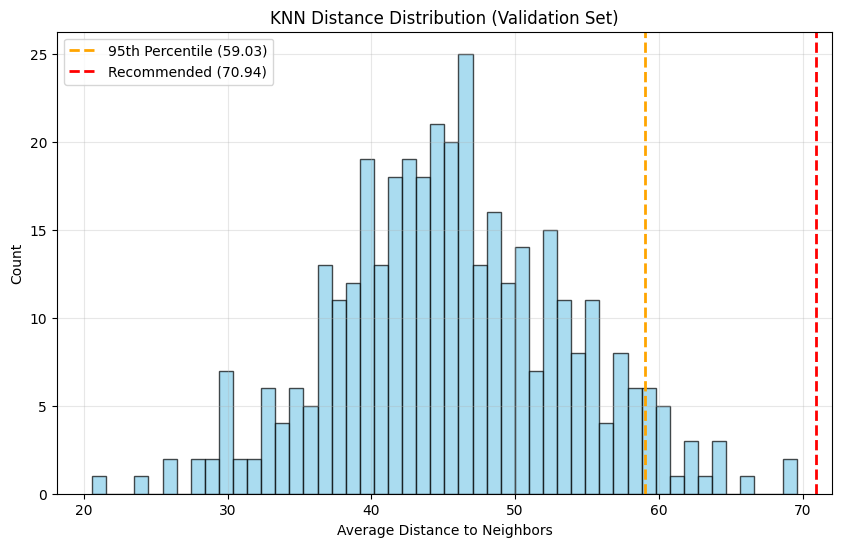

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# CONFIGURATION
MODEL_DIR = '/content/drive/MyDrive/CNN/saved_models'
DATA_DIR = '/content/drive/MyDrive/CNN/features'
KNN_MODEL_PATH = os.path.join(MODEL_DIR, 'knn_model.pkl')

def calculate_threshold():
    print("=" * 60)
    print("KNN DISTANCE THRESHOLD CALCULATOR")
    print("=" * 60)

    # 1. Load Data and Model
    print(f"[INFO] Loading data from {DATA_DIR}...")
    try:
        X_train = np.load(os.path.join(DATA_DIR, 'X_train.npy'))
        X_val = np.load(os.path.join(DATA_DIR, 'X_val.npy'))
        y_val = np.load(os.path.join(DATA_DIR, 'y_val.npy'))

        print(f"[INFO] Loading KNN model from {KNN_MODEL_PATH}...")
        with open(KNN_MODEL_PATH, 'rb') as f:
            knn = pickle.load(f)
    except FileNotFoundError as e:
        print(f"[ERROR] {e}")
        print("Please ensure you have run the training phases first.")
        return

    # 2. Calculate Distances for Validation Data
    # We use validation data because it wasn't used to build the tree,
    # so it simulates 'new' data better than training data.
    print("[INFO] Calculating distances for validation set...")

    # kneighbors returns (distances, indices)
    # distances shape: (num_samples, n_neighbors)
    distances, _ = knn.kneighbors(X_val)

    # We care about the average distance to the k neighbors
    mean_distances = distances.mean(axis=1)

    # 3. Analyze the Statistics
    min_dist = np.min(mean_distances)
    max_dist = np.max(mean_distances)
    avg_dist = np.mean(mean_distances)
    std_dist = np.std(mean_distances)

    # Calculate percentiles (safe zones)
    p95 = np.percentile(mean_distances, 95)
    p99 = np.percentile(mean_distances, 99)

    print("\n" + "-" * 40)
    print("DISTANCE STATISTICS (KNOWN CLASSES)")
    print("-" * 40)
    print(f"Min Distance:     {min_dist:.4f}")
    print(f"Average Distance: {avg_dist:.4f}")
    print(f"Max Distance:     {max_dist:.4f}")
    print(f"Std Deviation:    {std_dist:.4f}")
    print("-" * 40)
    print(f"95% of data is below: {p95:.4f}")
    print(f"99% of data is below: {p99:.4f}")
    print("-" * 40)

    # 4. Recommendation Logic
    # A safe threshold is usually Mean + 3*StdDev or the 99th percentile.
    # We want to accept 99% of valid images, and reject anything further out.
    recommended_threshold = p99 * 1.1  # Add 10% buffer

    print(f"\n[RECOMMENDATION] Suggested Threshold: {recommended_threshold:.2f}")
    print(f"(Use this value for 'dist_threshold' in your predict function)")

    # 5. Visual Histogram
    # This chart helps you verify if the threshold makes sense visually
    plt.figure(figsize=(10, 6))
    plt.hist(mean_distances, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(p95, color='orange', linestyle='--', linewidth=2, label=f'95th Percentile ({p95:.2f})')
    plt.axvline(recommended_threshold, color='red', linestyle='--', linewidth=2, label=f'Recommended ({recommended_threshold:.2f})')

    plt.title('KNN Distance Distribution (Validation Set)')
    plt.xlabel('Average Distance to Neighbors')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)

    save_path = os.path.join(MODEL_DIR, 'knn_distance_distribution.png')
    plt.savefig(save_path)
    print(f"\n[GRAPH] Saved distribution plot to {save_path}")
    plt.show()

if __name__ == "__main__":
    calculate_threshold()

#### **Cell 8: Prediction Pipeline (Phase 4)**

* **What it does:** Loads the model and tests it on new images.

In [ ]:
import pickle
import json
import numpy as np
import cv2
import torch
import torch.nn as nn
from torchvision import models, transforms
from pathlib import Path
import csv

# Image preprocessing configuration (must match training)
IMAGE_SIZE = 128

# Class mapping
CLASS_MAPPING = {
    0: 'cardboard', 1: 'glass', 2: 'metal',
    3: 'paper', 4: 'plastic', 5: 'trash', 6: 'unknown'
}


def load_model_and_scaler(bestModelPath, model_type):
    """
    Load the trained SVM/KNN model, feature scaler, and CNN backbone

    Args:
        bestModelPath: Path to the saved_models directory

    Returns:
        model: Trained classifier (SVM or KNN)
        scaler: Feature scaler
        cnn_model: CNN feature extractor
        device: torch device
        transform: Image transformation pipeline
    """
    model_dir = Path(bestModelPath)

    # Determine device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Using device: {device}")

    # Load CNN backbone for feature extraction
    print("[INFO] Loading CNN feature extractor...")
    cnn_path = model_dir / 'cnn_feature_extractor.pth'

    if not cnn_path.exists():
        raise FileNotFoundError(f"CNN model not found at {cnn_path}")

    cnn_model = models.resnet50(pretrained=False)
    cnn_model.fc = nn.Identity()  # Remove classifier head

    state = torch.load(cnn_path, map_location=device)
    cnn_model.load_state_dict(state, strict=False)
    cnn_model = cnn_model.to(device)
    cnn_model.eval()

    # Load feature scaler
    print("[INFO] Loading feature scaler...")
    scaler_path = model_dir / 'feature_scaler.pkl'

    if not scaler_path.exists():
        raise FileNotFoundError(f"Feature scaler not found at {scaler_path}")

    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # Load classifier model (try SVM first, then KNN)
    model = None
    model_type = model_type

    if model_type == 'svm':
        svm_path = model_dir / 'svm_model.pkl'
        print("[INFO] Loading SVM model...")
        with open(svm_path, 'rb') as f:
            model = pickle.load(f)
        model_type = 'svm'

        # Load SVM config for threshold
        config_path = model_dir / 'svm_config.json'
        if config_path.exists():
            with open(config_path, 'r') as f:
                config = json.load(f)
            threshold = config.get('optimal_threshold', 0.6)
        else:
            threshold = 0.6
    elif model_type == 'knn':
        knn_path = model_dir / 'knn_model.pkl'
        print("[INFO] Loading KNN model...")
        with open(knn_path, 'rb') as f:
            model = pickle.load(f)
        model_type = 'knn'
        threshold = None  # KNN doesn't use threshold
    else:
        raise FileNotFoundError(f"No model found in {model_dir}")

    if model is None:
        raise RuntimeError("Failed to load any model")

    print(f"[OK] Loaded {model_type.upper()} model successfully")

    # Define image transformation pipeline
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    return model, scaler, cnn_model, device, transform, model_type, threshold


def load_images_from_folder(dataFilePath):
    """
    Load all images from the given folder path

    Args:
        dataFilePath: Path to folder containing images

    Returns:
        images: List of (image_array, filename) tuples
    """
    folder_path = Path(dataFilePath)

    if not folder_path.exists():
        raise FileNotFoundError(f"Folder not found: {dataFilePath}")

    # Supported image extensions
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}

    # Load all images
    images = []
    image_files = []

    for file_path in sorted(folder_path.iterdir()):
        if file_path.suffix.lower() in valid_extensions:
            try:
                # Read image using OpenCV
                img = cv2.imread(str(file_path))

                if img is None:
                    print(f"[WARNING] Failed to load: {file_path.name}")
                    continue

                # Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                images.append(img)
                image_files.append(file_path.name)

            except Exception as e:
                print(f"[WARNING] Error loading {file_path.name}: {e}")
                continue

    print(f"[INFO] Loaded {len(images)} images from {dataFilePath}")

    return images, image_files


def extract_features(images, cnn_model, scaler, transform, device):
    """
    Extract CNN features from images

    Args:
        images: List of image arrays
        cnn_model: CNN feature extractor
        scaler: Feature scaler
        transform: Image transformation pipeline
        device: torch device

    Returns:
        features: Numpy array of extracted and scaled features
    """
    features_list = []

    print("[INFO] Extracting features...")

    with torch.no_grad():
        for i, img in enumerate(images):
            try:
                # Validate image
                if img is None or img.size == 0:
                    features_list.append(np.zeros(2048))
                    continue

                if img.ndim != 3 or img.shape[2] != 3:
                    features_list.append(np.zeros(2048))
                    continue

                # Ensure uint8
                img = np.clip(img, 0, 255).astype(np.uint8)

                # Transform image
                img_tensor = transform(img).unsqueeze(0).to(device)

                # Extract features
                feature_vector = cnn_model(img_tensor)
                feature_vector = feature_vector.cpu().numpy().reshape(1, -1)

                # Normalize with scaler
                feature_vector = scaler.transform(feature_vector)

                features_list.append(feature_vector.flatten())

            except Exception as e:
                print(f"[WARNING] Error extracting features for image {i}: {e}")
                features_list.append(np.zeros(2048))

    features = np.array(features_list)
    print(f"[OK] Extracted features with shape: {features.shape}")

    return features


def make_predictions(model, features, model_type, threshold=None):
    """
    Make predictions using the loaded model

    Args:
        model: Trained classifier
        features: Feature array
        model_type: 'svm' or 'knn'
        threshold: Confidence threshold for SVM (optional)

    Returns:
        predictions: List of predicted class names
        confidences: List of confidence scores
    """
    predictions = []
    confidences = []

    print("[INFO] Making predictions...")

    if model_type == 'svm':
        # SVM with confidence thresholding
        probabilities = model.predict_proba(features)

        for prob in probabilities:
            max_prob = prob.max()
            class_id = prob.argmax()

            # Apply rejection threshold
            # REJECTION MECHANISM
            # If the model is not confident enough, force 'unknown'
            if threshold is not None and max_prob < threshold:
                class_id = 6  # Unknown class
                print(f"   -> Rejected sample (Conf: {max_prob:.2f} < {threshold})")

            class_name = CLASS_MAPPING.get(class_id, 'unknown')
            predictions.append(class_name)
            confidences.append(max_prob)
    # --- KNN STRATEGY: DISTANCE THRESHOLD ---
    elif model_type == 'knn':
        # 1. Get neighbors and distances
        # kneighbors returns (distances, indices) for the k nearest neighbors
        # This tells us HOW FAR the test image is from the training images
        distances, indices = model.kneighbors(features)

        # 2. Calculate the average distance to the k neighbors
        mean_distances = distances.mean(axis=1)

        # 3. Predict based on voting (standard KNN)
        raw_predictions = model.predict(features)

        # 4. REJECTION MECHANISM
        # If threshold is None, default to a safe value (e.g. 15.0 - requires tuning)
        # Higher distance = Image is very different from training data
        dist_threshold = threshold if threshold is not None else 15.0
        # dist_threshold = the ouput number of the previous cell

        for i, (pred_id, dist) in enumerate(zip(raw_predictions, mean_distances)):
            final_id = pred_id

            # If the image is too far away from known samples -> Unknown
            if dist > dist_threshold:
                final_id = 6  # Force Unknown ID
                print(f"   -> Rejected sample (Dist: {dist:.2f} > {dist_threshold})")

            # Create a confidence score (inverse of distance) for display
            # Closer distance = Higher confidence
            confidence = 1.0 / (1.0 + dist)

            class_name = CLASS_MAPPING.get(final_id, 'unknown')
            predictions.append(class_name)
            confidences.append(confidence)

  # elif model_type == 'knn':
  #     # KNN prediction
  #     if hasattr(model, 'predict_proba'):
  #         probabilities = model.predict_proba(features)

  #         for prob in probabilities:
  #             max_prob = prob.max()
  #             class_id = prob.argmax()
  #             class_name = CLASS_MAPPING.get(class_id, 'unknown')
  #             predictions.append(class_name)
  #             confidences.append(max_prob)
  #     else:
  #         # KNN without probabilities
  #         class_ids = model.predict(features)
  #         predictions = [CLASS_MAPPING.get(cid, 'unknown') for cid in class_ids]
  #         confidences = [1.0] * len(predictions)  # Placeholder

    else:
        # Simple prediction without threshold
        class_ids = model.predict(features)
        predictions = [CLASS_MAPPING.get(cid, 'unknown') for cid in class_ids]

        # Try to get confidence scores
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(features)
            confidences = [prob.max() for prob in probabilities]
        else:
            confidences = [1.0] * len(predictions)

    print(f"[OK] Generated {len(predictions)} predictions")

    return predictions, confidences


def predict(dataFilePath, bestModelPath, model_type, manual_threshold=None):
    """
    Main prediction function with CSV export
    """
    try:
        print("\n" + "=" * 70)
        print("PREDICTION PIPELINE")
        print("=" * 70)
        print(f"Data folder: {dataFilePath}")
        print(f"Model path: {bestModelPath}")
        print()

        # Step 1: Load model and preprocessing components
        model, scaler, cnn_model, device, transform, model_type, loaded_threshold = load_model_and_scaler(bestModelPath, model_type)

        # PRIORITY LOGIC:
        # 1. Use manual_threshold if provided (for testing)
        # 2. Else use loaded_threshold from config file
        # 3. Else default to 0.6
        if manual_threshold is not None:
            final_threshold = manual_threshold
        elif loaded_threshold is not None:
            final_threshold = loaded_threshold
        else:
            final_threshold = 0.6

        print(f"[CONFIG] Using Rejection Threshold: {final_threshold} for {model_type}")

        # Step 2: Load images from folder
        images, image_files = load_images_from_folder(dataFilePath)

        if len(images) == 0:
            print("[WARNING] No valid images found in folder")
            return []

        # Step 3: Extract features
        features = extract_features(images, cnn_model, scaler, transform, device)

        # Step 4: Make predictions
        predictions, confidences = make_predictions(model, features, model_type, final_threshold)

        # Step 5: Display results
        print("\n" + "=" * 70)
        print("PREDICTION RESULTS")
        print("=" * 70)
        print(f"{'Image':<30} {'Prediction':<15} {'Confidence':<10}")
        print("-" * 70)

        for img_name, pred, conf in zip(image_files, predictions, confidences):
            print(f"{img_name:<30} {pred:<15} {conf:.4f}")

        print("=" * 70 + "\n")

        # =========================================================
        # Step 6: Save Results to CSV [NEW ADDITION]
        # =========================================================
        # Save in a 'results' folder next to your 'saved_models' folder
        results_dir = Path('/content/results')
        results_dir.mkdir(parents=True, exist_ok=True)

        csv_filename = f"prediction_results_{model_type}.csv"
        csv_path = results_dir / csv_filename

        print(f"[SAVING] Saving results to CSV: {csv_path}")

        try:
            with open(csv_path, mode='w', newline='') as f:
                writer = csv.writer(f)
                # Write Header
                writer.writerow(['Image Name', 'Prediction', 'Confidence', 'Threshold Used'])

                # Write Rows
                for img_name, pred, conf in zip(image_files, predictions, confidences):
                    writer.writerow([img_name, pred, f"{conf:.4f}", final_threshold])

            print(f"[OK] CSV saved successfully!")
        except Exception as e:
            print(f"[ERROR] Could not save CSV: {e}")

        return predictions

    except Exception as e:
        print(f"\n[ERROR] Prediction failed: {e}")
        import traceback
        traceback.print_exc()
        return []


if __name__ == "__main__":
    dataFilePath = "/content/drive/MyDrive/testset-E"
    bestModelPath = "/content/drive/MyDrive/CNN/saved_models"

    # CHANGE THIS VALUE to the one you saw in Cell 7 output
    MY_KNN_THRESHOLD = 70.94

    # Run prediction
    results = predict(dataFilePath, bestModelPath, model_type='svm')
    # results = predict(dataFilePath, bestModelPath, model_type='knn', manual_threshold=MY_KNN_THRESHOLD)

    print(f"\n[SUMMARY] Predicted {len(results)} images")
    print(f"[RESULTS] {results}")


PREDICTION PIPELINE
Data folder: /content/drive/MyDrive/testset-E
Model path: /content/drive/MyDrive/CNN/saved_models

[INFO] Using device: cuda
[INFO] Loading CNN feature extractor...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[INFO] Loading feature scaler...
[INFO] Loading SVM model...
[OK] Loaded SVM model successfully
[CONFIG] Using Rejection Threshold: 0.3 for svm
[INFO] Loaded 60 images from /content/drive/MyDrive/testset-E
[INFO] Extracting features...
[OK] Extracted features with shape: (60, 2048)
[INFO] Making predictions...
[OK] Generated 60 predictions

PREDICTION RESULTS
Image                          Prediction      Confidence
----------------------------------------------------------------------
(1).jpg                        paper           0.9083
(10).jpg                       paper           0.9681
(11).jpg                       plastic         0.8013
(12).jpg                       plastic         0.8283
(13).jpg                       plastic         0.9734
(14).jpg                       plastic         0.8649
(15).jpg                       glass           0.5900
(16).jpg                       plastic         0.5602
(17).jpg                       plastic         0.9080
(18).jpg               